# Load Dependencies and Check GPU Status

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Build Dataloading Function

In [2]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# Create TensorFlow Dataset

In [3]:
# define paths to positive and negative data
BAD = os.path.join("C:/Users/jreye/AudioAudio/Bad") 
NOT_BAD = os.path.join("C:/Users/jreye/Documents/GoogleSpeech_V2/TRAINING_1")

# create TensorFlow datasets
pos = tf.data.Dataset.list_files(BAD+'\*.wav') 
neg = tf.data.Dataset.list_files(NOT_BAD+'\*.wav')

# add labels and combine positive and negative samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(pos)))))
data = positives.concatenate(negatives)
data.shuffle(10000).as_numpy_iterator().next()

(b'C:\\Users\\jreye\\Documents\\GoogleSpeech_V2\\TRAINING_1\\happy(35).wav',
 0.0)

# Build Preprocessing Function to Convert to Spectrogram

In [4]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:35000] # 35000 sample length (can make smaller to reduce processing time but will affect accuracy)
    zero_padding = tf.zeros([35000] - tf.shape(wav), dtype=tf.float32) 
    wav = tf.concat([zero_padding, wav],0) # pad clips longer than 25000 samples wiht zeros
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

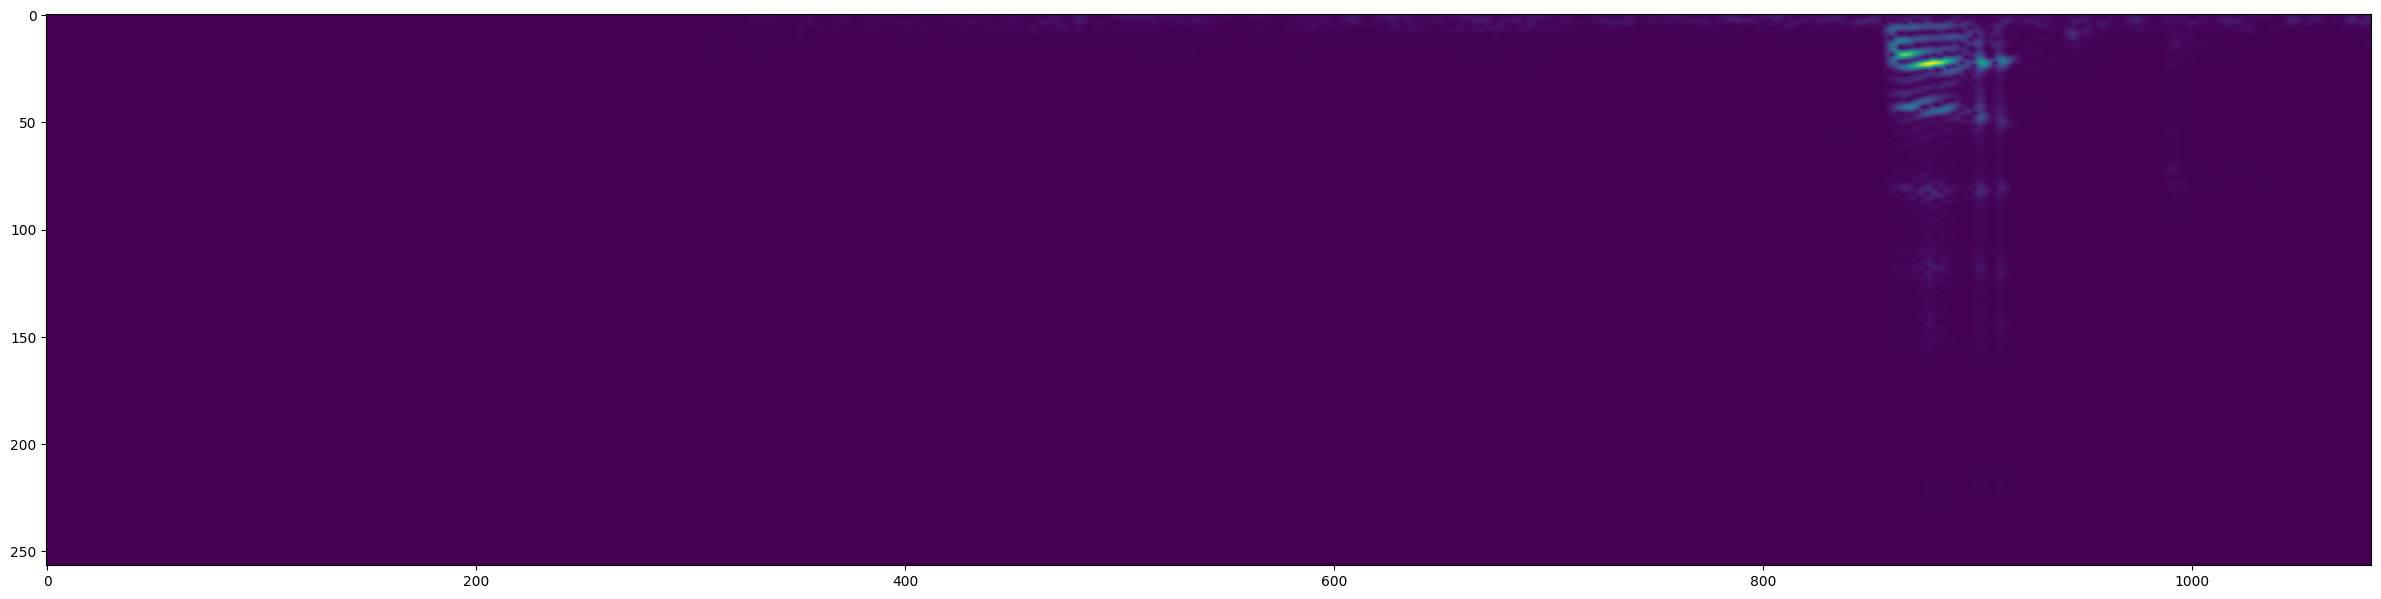

In [5]:
# test out the function and visualize the spectrogram (bad words)
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Create Training and Testing Partitions

In [6]:
len(data)

312

In [7]:
# create TensorFlow data pipeline
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(8)
data = data.prefetch(4)

In [8]:
len(data)

39

In [9]:
# split into training and testing partitions
train = data.take(27) # 70 % goes to train set
test = data.skip(27).take(12) # 30 % goes to test set

In [10]:
# test one batch
samples, labels = train.as_numpy_iterator().next()

In [11]:
samples.shape

(8, 1084, 257, 1)

In [12]:
labels

array([1., 0., 1., 1., 1., 0., 1., 0.], dtype=float32)

# Build Deep Learning Model

In [13]:
# load Keras Model dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Activation
from tensorflow.keras.callbacks import TensorBoard # to view statistics
import time

# Training Various Configurations of Model

In [14]:
# things we can test while training
# optimizer type
    # learning rate
# dense layers (whether we use them or we dont)
    # how many units per layer
    # kernel size
    # stride
    # decay/decay rate
    
# test various configs of model
dense_layers = [1] # 1 worked well so we check 0 and 2
layer_sizes = [16] # 16 worked well so we check 8 and 32
conv_layers = [1] # 2 worked well so we check 1 and 3
dense_size = 128

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            # create layers
            model = Sequential()
            model.add(Conv2D(layer_size, (3,3), input_shape= (1084, 257, 1))) # depends on shape of spec
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2,2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3,3)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2)))

            model.add(Flatten())
            for l in range(dense_layer):
                model.add(Dense(dense_size))
                model.add(Activation("relu"))

            # output layer
            model.add(Dense(1))
            model.add(Activation("sigmoid"))

            tensorboard = TensorBoard(log_dir='bad_mouth_logs/{}'.format(NAME))

            model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

            # tensorboard analysis
            hist = model.fit(train, epochs=4, validation_data=test, callbacks = [tensorboard])

1-conv-16-nodes-1-dense-1676341537
Epoch 1/4
27/27 [==============================] - 3s 38ms/step - loss: 2.7450 - recall: 0.6961 - precision: 0.5868 - val_loss: 0.5382 - val_recall: 0.5455 - val_precision: 0.8889
Epoch 2/4
27/27 [==============================] - 1s 32ms/step - loss: 0.5387 - recall: 0.5278 - precision: 0.8028 - val_loss: 0.5330 - val_recall: 0.7250 - val_precision: 0.8056
Epoch 3/4
27/27 [==============================] - 1s 32ms/step - loss: 0.4589 - recall: 0.6852 - precision: 0.8506 - val_loss: 0.3834 - val_recall: 0.6400 - val_precision: 0.8649
Epoch 4/4
27/27 [==============================] - 1s 32ms/step - loss: 0.3472 - recall: 0.7434 - precision: 0.8660 - val_loss: 0.2694 - val_recall: 0.8542 - val_precision: 0.9535


# Fit Model, View Loss, and KPI Plots

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1082, 255, 16)     160       
                                                                 
 activation (Activation)     (None, 1082, 255, 16)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 541, 127, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1099312)           0         
                                                                 
 dense (Dense)               (None, 128)               140712064 
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                        

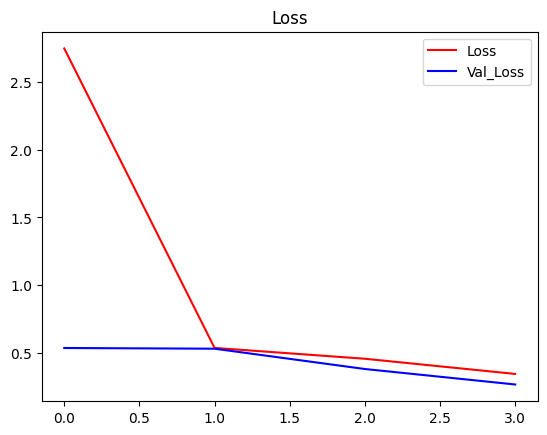

In [16]:
# plot loss 
# mean error across samples for each epoch (runthrough entire dataset)
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.legend(["Loss", "Val_Loss"])
plt.show()

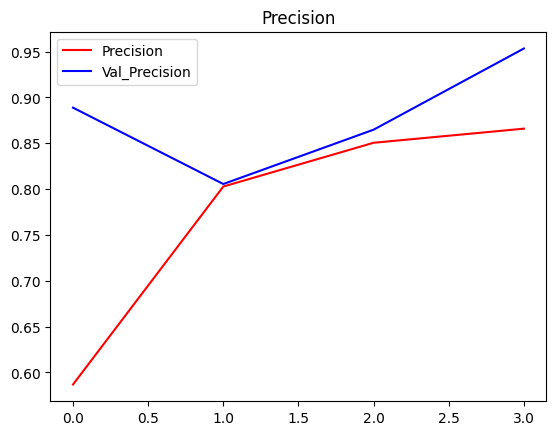

In [17]:
# plot precision
# the percent of positive predicitions that were correct (good and bad)
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.legend(["Precision", "Val_Precision"])
plt.show()

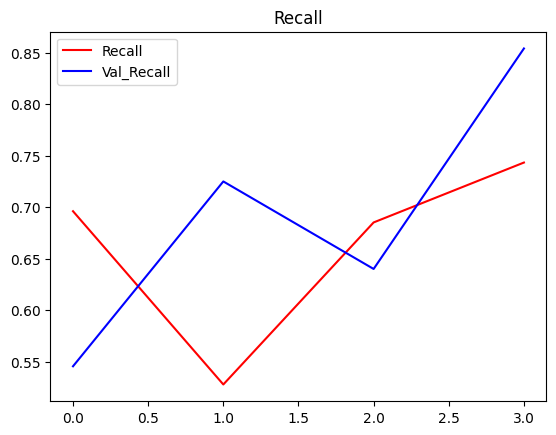

In [18]:
# plot recall
# the percentage of positive predicitions that were correct (only bad words)
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.legend(["Recall", "Val_Recall"])
plt.show()

# Make a Prediction on a Single Clip

In [19]:
# get one batch and make a prediction
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

# Convert logits to classes
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat

1/1 [==============================] - 0s 56ms/step


[1, 0, 1, 1, 0, 0, 1, 1]

In [20]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [21]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>

In [22]:
y_test.astype(int)

array([1, 0, 1, 1, 0, 0, 1, 1])

# Save the Model

In [169]:
model.save('bad_mouth_1c_16n_1d.model')
# how to load model
# new_model = tf.keras.models.load_model('bad_mouth.model')

INFO:tensorflow:Assets written to: bad_mouth_1c_16n_1d.model\assets


INFO:tensorflow:Assets written to: bad_mouth_1c_16n_1d.model\assets


# Convert to TF Lite

In [ ]:
TF_LITE_MODEL_FILE_NAME = "bad_mouth_lite.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\jreye\AppData\Local\Temp\tmpnh5y69gc\assets


INFO:tensorflow:Assets written to: C:\Users\jreye\AppData\Local\Temp\tmpnh5y69gc\assets


In [ ]:
# check input tensor shape
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")